In [1]:
import numpy as np
import matplotlib.pyplot as plt

#from sar_geometry import *
#from sar_functions import *
#from supplemental import *
import sys
sys.path.insert(1, '/Users/bhills/Software/squintsar/squintsar/lib/')
from supplemental import calc_dist, dB, r2p
from sar_geometry import sar_raybend, get_depth_dist
from sar_functions import matched_filter
from squintsar import sar_extent, fill_reference_array, sar_compression

In [2]:
# define the geometry
c = 3e8
t0 = 4e-6     # range to target at closest approach (assume x0 is 0)
h = 500 # height above ice surface
dx = .1        # x step
Xs = np.arange(-100.,100+dx,dx) # along-track distances within the synthetic aperture

# for a given squint angle (theta) find the depth in ice 
# and along-track distance (x0) from center of aperture to target
theta_sq = 1e-10*np.pi/180.
r0 = t0*c
# range offset within aperture - air only so simple geometry
R1_air = (np.sqrt(r0**2.+Xs**2.) - r0)/c
# range offset within aperture - with ice so ray bending
R1_ice = sar_raybend(t0, h, Xs, theta_sq)

# again with non-zero squint
theta_sq = -3.*np.pi/180.
# range offset within aperture - air only so simple geometry
x0 = r0*np.sin(theta_sq)   # distance from center of aperture to closest approach
h_air = r0*np.cos(theta_sq)    # vertical height above target at closest approach
R2_air = (np.sqrt(h_air**2.+(Xs-x0)**2.) - h_air)/c
# range offset within aperture - with ice so ray bending
d, x0 = get_depth_dist(t0,h,theta_sq)
R2_ice = sar_raybend(t0, h, Xs, theta_sq)

/Users/bhills/Software/squintsar/squintsar/lib/sar_geometry.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  s[i] = roots[np.argmin(abs(roots))]


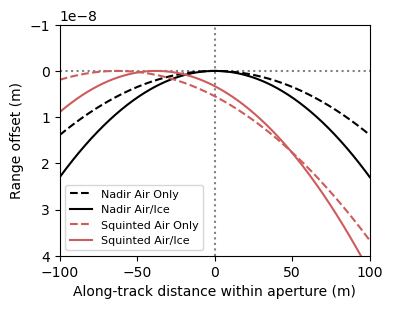

In [3]:
# Plot the range-offset function
plt.figure(figsize=(4,3))
plt.axhline(0,color='grey',ls=':')
plt.axvline(0,color='grey',ls=':')
plt.plot(Xs,R1_air,'k',ls='--',label='Nadir Air Only')
plt.plot(Xs,R1_ice,'k',label='Nadir Air/Ice')
plt.plot(Xs,R2_air,'indianred',ls='--',label='Squinted Air Only')
plt.plot(Xs,R2_ice,'indianred',label='Squinted Air/Ice')
plt.legend(fontsize=8)
plt.xlabel('Along-track distance within aperture (m)')
plt.ylabel('Range offset (m)')
plt.ylim(4e-8,-1e-8)
plt.xlim(min(Xs),max(Xs));

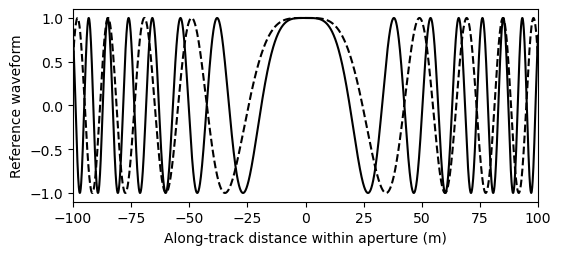

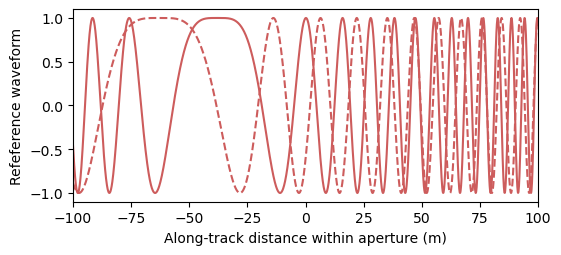

In [4]:
# Calculate and plot the matched filter for no squint
plt.figure(figsize=(6,2.5))
C = matched_filter(r2p(R1_air))
plt.plot(Xs,np.real(C),'k--')
C = matched_filter(r2p(R1_ice))
plt.plot(Xs,np.real(C),'k-')
plt.xlabel('Along-track distance within aperture (m)')
plt.ylabel('Reference waveform')
plt.xlim(min(Xs),max(Xs));

# Calculate and plot the matched filter with squint
plt.figure(figsize=(6,2.5))
C = matched_filter(r2p(R2_air))
plt.plot(Xs,np.real(C),'--',c='indianred')
C = matched_filter(r2p(R2_ice))
plt.plot(Xs,np.real(C),'-',c='indianred')
plt.xlabel('Along-track distance within aperture (m)')
plt.ylabel('Refeference waveform')
plt.xlim(min(Xs),max(Xs));

In [5]:
### instrument properties
fc = 150e6 # center frequency
L_a = 7.5 # antenna length
theta_beam = 0.866 * 3e8/(fc*L_a) # "half-power beamwidth" of the antenna with respect to its Length

c = 3e8
t0 = 4e-6
h = 500
dt = 2e-8
dx = 0.1
theta_sq = -3.*np.pi/180.

fasttime = np.arange(0,t0,dt)

C_ref = fill_reference_array(fasttime,h,theta_sq,theta_beam,dx)

d, x0 = get_depth_dist(max(fasttime), h, theta_sq)
Xs, ind0max, ind_max = sar_extent(max(fasttime), h, theta_sq, theta_beam, dx=dx)
if ind0max > 0:
    ind0max = 0
    Xs = np.arange(0, max(Xs)-x0, dx) + x0
if ind_max < 0:
    ind_max = 0
    Xs = np.arange(min(Xs)-x0, 0, dx) + x0

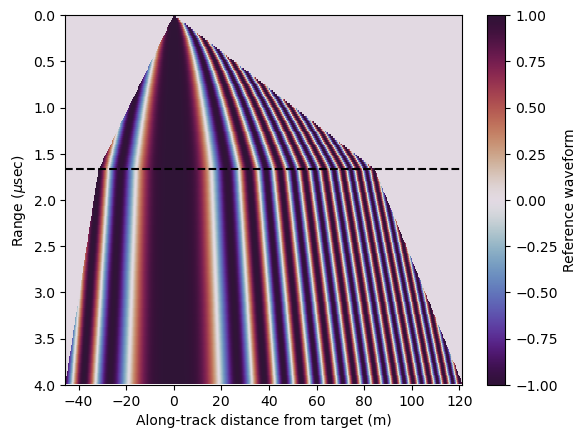

In [6]:
plt.figure()
plt.pcolormesh(Xs-x0,fasttime*1e6,np.real(C_ref),cmap='twilight_shifted')
plt.colorbar(label='Reference waveform')
plt.ylim(t0*1e6,0)
plt.axhline(h/c*1e6,color='k',linestyle='--')
plt.xlabel('Along-track distance from target (m)')
plt.ylabel('Range ($\mu$sec)');

In [15]:
%%time

tnum = 5000
snum = len(fasttime)
image_rc = np.random.rand(snum,tnum) + 1j*np.random.rand(snum,tnum)

image_rcac = sar_compression(image_rc, C_ref, ind_max, ind0max, domain='freq')
print(np.shape(image_rc),np.shape(image_rcac))

plt.figure()
plt.imshow(np.real(image_rcac),aspect='auto')

ValueError: operands could not be broadcast together with shapes (5000,) (1667,) 